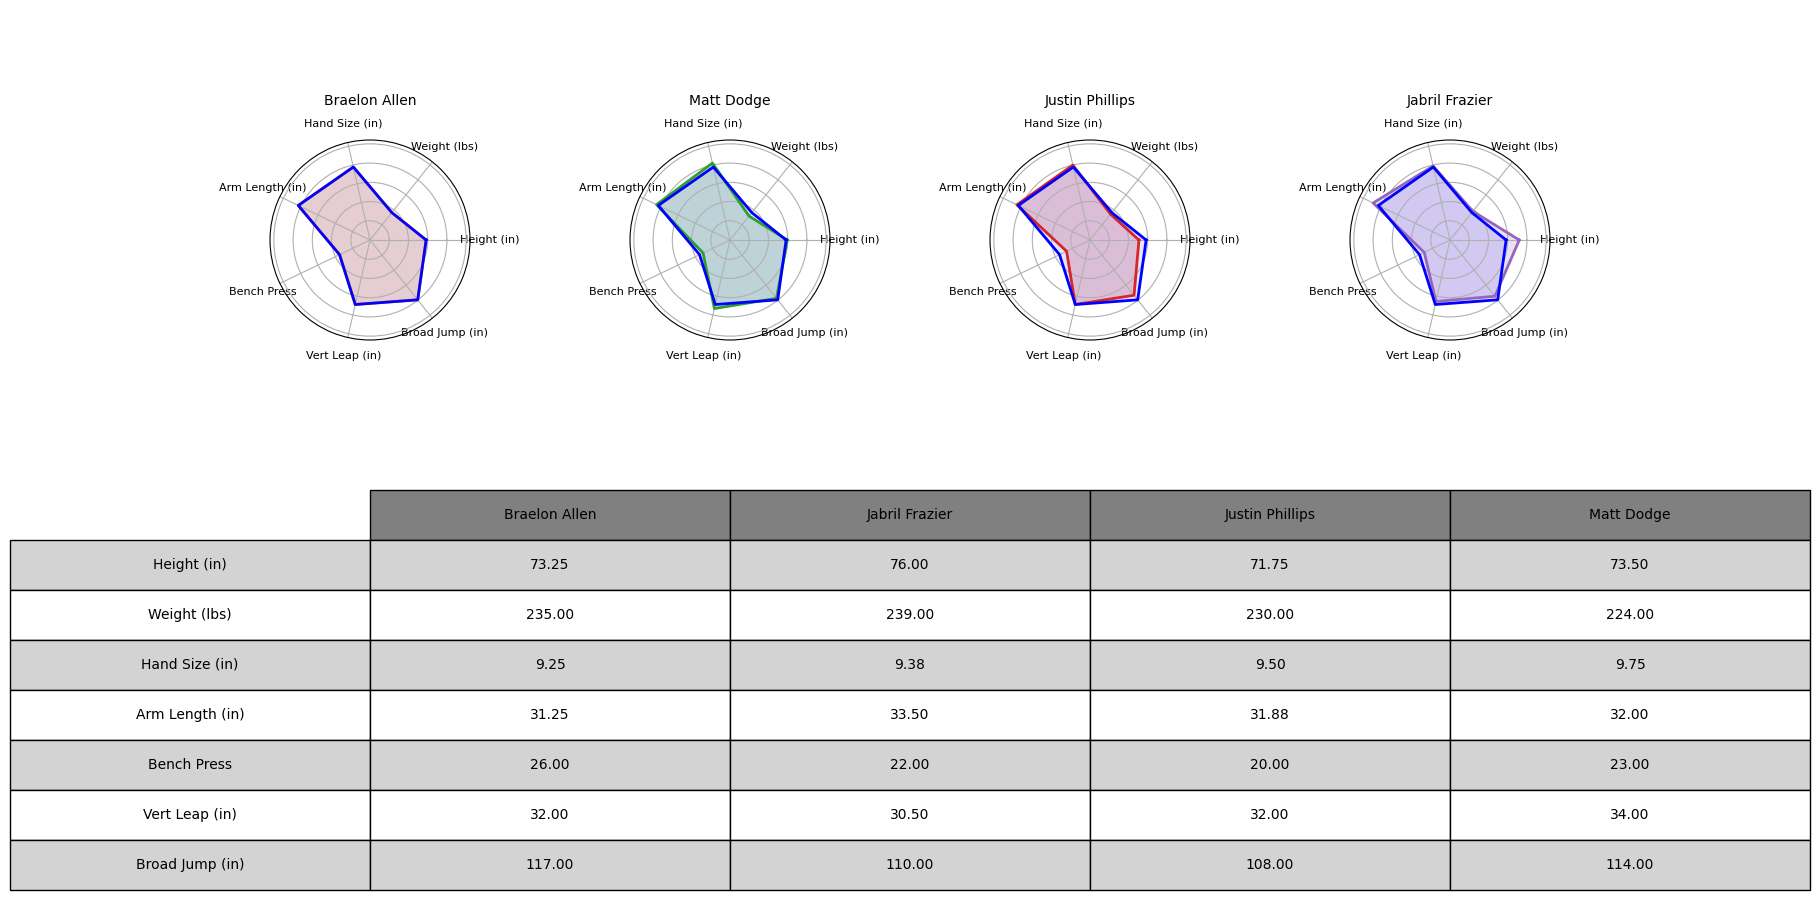

In [35]:
import matplotlib.pyplot as plt
from matplotlib.table import Table
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler

# Load the CSV
file_path = "combine_data.csv"
df = pd.read_csv(file_path)


input_player = "Braelon Allen"
input_row = df[df['Name'] == input_player].iloc[0]
numeric_cols = [
    col for col in df.select_dtypes(include=['float64', 'int64']).columns if col not in ['Id', 'Year']
]

lower_better_metrics = ['40 Yard', '60Yd Shuttle', '3Cone', 'Shuttle']


scaler = MinMaxScaler()
df_normalized = df[numeric_cols].copy()

for col in lower_better_metrics:
    if col in df_normalized.columns:
        df_normalized[col] = -df_normalized[col]  


df_normalized = df_normalized.fillna(0)
df_normalized = pd.DataFrame(
    scaler.fit_transform(df_normalized), columns=numeric_cols, index=df.index
)


input_vector = df_normalized.loc[df['Name'] == input_player].values
similarities = cosine_similarity(input_vector, df_normalized.values).flatten()


df['Similarity'] = similarities
top_comparisons = df[df['Name'] != input_player].nlargest(3, 'Similarity')
comparison_players = [input_player] + top_comparisons['Name'].tolist()

# Prepare data for radar chart
metrics = [metric for metric in numeric_cols if not pd.isnull(input_row[metric])]
data_for_radar = [
    df_normalized.loc[df['Name'] == player, metrics].values.flatten().tolist()
    for player in comparison_players
]


fig, ax = plt.subplots(figsize=(18, 10))  
ax.set_axis_off()

radar_height = 0.2
radar_width = 0.2
radar_y = 0.55  
radar_x_start = 0.1
radar_x_spacing = (1 - radar_x_start * 2) / len(comparison_players)

angles = np.linspace(0, 2 * np.pi, len(metrics), endpoint=False).tolist()
angles += angles[:1]

# Transpose the comparison data for the table
comparison_data = df.loc[df['Name'].isin(comparison_players), ['Name'] + metrics]
comparison_data.set_index("Name", inplace=True)
comparison_data_transposed = comparison_data.transpose()


for i, (player, player_data) in enumerate(zip(comparison_players, data_for_radar)):
    player_data += player_data[:1]  
    ax_position = [radar_x_start + i * radar_x_spacing, radar_y, radar_width, radar_height]
    radar_ax = fig.add_axes(ax_position, polar=True)


    for j in range(1, 6):
        radar_ax.fill(
            [j / 5 * 2 * np.pi for _ in range(len(metrics) + 1)],
            [j / 5] * (len(metrics) + 1),
            color="gray" if j % 2 == 0 else "white",
            alpha=0.3,
        )


    radar_ax.plot(angles, player_data, color=f"C{i+1}", linewidth=2)
    radar_ax.fill(angles, player_data, color=f"C{i+1}", alpha=0.2)


    radar_ax.plot(angles, data_for_radar[0], color="blue", linewidth=2)
    radar_ax.fill(angles, data_for_radar[0], color="blue", alpha=0.1)

    radar_ax.set_yticklabels([])
    radar_ax.set_xticks(angles[:-1])
    radar_ax.set_xticklabels(metrics, fontsize=8, rotation=45)
    radar_ax.set_title(player, fontsize=10, pad=10)


table_ax = fig.add_axes([0, 0, 1, 0.4])  
table_ax.set_axis_off()
table = Table(table_ax, bbox=[0, 0, 1, 1])

nrows, ncols = comparison_data_transposed.shape
cell_width = 1 / (ncols + 1)
cell_height = 1 / (nrows + 1)


for j, column in enumerate(comparison_data_transposed.columns):
    table.add_cell(0, j + 1, cell_width, cell_height, text=column, loc="center", facecolor="gray")


for i, row_name in enumerate(comparison_data_transposed.index):
    table.add_cell(i + 1, 0, cell_width, cell_height, text=row_name, loc="center", facecolor="gray")

# Add data cells
for i, row in enumerate(comparison_data_transposed.values):
    for j, value in enumerate(row):
        table.add_cell(i + 1, j + 1, cell_width, cell_height, text=f"{value:.2f}" if pd.notnull(value) else "N/A", loc="center")


for i in range(1, nrows + 1):
    for j in range(ncols + 1):
        table.get_celld()[(i, j)].set_facecolor("white" if i % 2 == 0 else "lightgray")

table_ax.add_table(table)
plt.show()
